Using TensorFlow backend.


10080
2880
1440
8640 2880


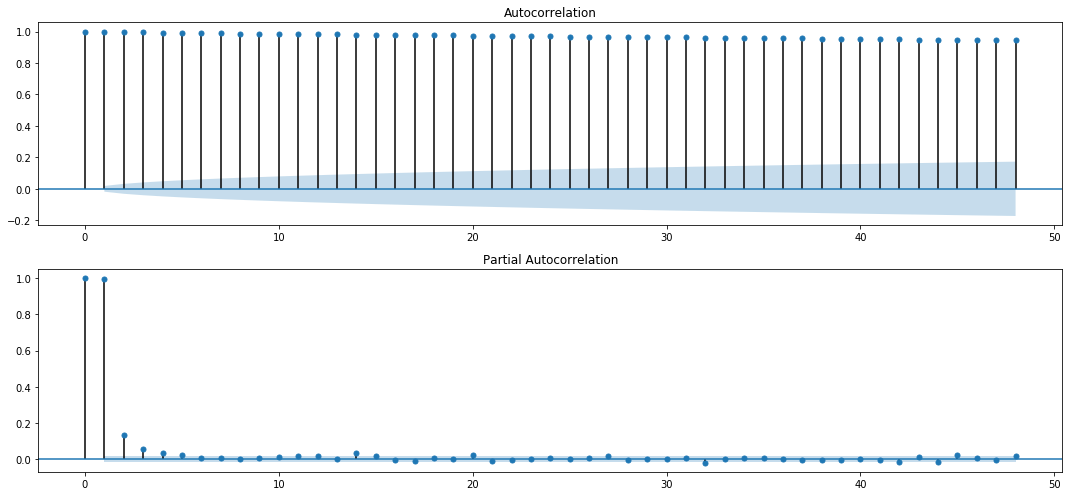

In [1]:
#================== gist_1

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

#================== gist_2

#data = pd.read_csv('../input/bitstampUSD_1-min_data_2012-01-01_to_2017-10-20.csv')
#data = pd.read_csv('/home/UFF/IA/Trabalho/Dados/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv')
data = pd.read_csv('/home/UFF/IA/Trabalho/Dados/Exp10diasVlLow.csv')
data.isnull().values.any()

#================== gist_3

data.head(10)


#================== gist_4

#data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date
#group = data.groupby('date')
#Daily_Price = group['Weighted_Price'].mean()
group = data.groupby('DataHora')
Daily_Price = group['VlLow'].mean()
Daily_Price.head()

#================== gist_5

Daily_Price.tail()

#================== gist_6

#from datetime import date
from datetime import datetime

#---- nota: delta.days devolve a diferença em dias excluindo o último dia... 9-1=8 (obvio)
#d0 = date(2016, 1, 1)
#d1 = date(2017, 10, 15)
d0 = datetime(2018, 6, 1, 0, 0, 0) #para extender a 100 dias, usar 2018-03-03
d1 = datetime(2018, 6, 7, 23, 59, 0)
delta = d1 - d0
#days_look = delta.days + 1
days_look = int((delta.days+1)*((delta.seconds/60) + 1))
print(days_look)

#d0 = date(2017, 8, 21)
#d1 = date(2017, 10, 20)
d0 = datetime(2018, 6, 8, 0, 0, 0) #para 10 dias de treinamento , usar 2018-06-02
d1 = datetime(2018, 6, 9, 23, 59, 0)
delta = d1 - d0
#days_from_train = delta.days + 1
days_from_train = int((delta.days+1)*((delta.seconds/60) + 1))
print(days_from_train)

#d0 = date(2017, 10, 15)
#d1 = date(2017, 10, 20)
d0 = datetime(2018, 6, 9, 0, 0, 0)
d1 = datetime(2018, 6, 9, 23, 59, 0)
delta = d1 - d0
#days_from_end = delta.days + 1
days_from_end = int((delta.days+1)*((delta.seconds/60) + 1))
print(days_from_end)

#================== gist_7

df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
df_test= Daily_Price[len(Daily_Price)-days_from_train:]

print(len(df_train), len(df_test))

#================== gist_8

working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
#working_data['date'] = pd.to_datetime(working_data['date'])
#working_data = working_data.set_index('date')
working_data['DataHora'] = pd.to_datetime(working_data['DataHora'])
working_data = working_data.set_index('DataHora')

#================== gist_9-10

#s = sm.tsa.seasonal_decompose(working_data.Weighted_Price.values, freq=60)
s = sm.tsa.seasonal_decompose(working_data.VlLow.values, freq=1440)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

#================== gist_11

plt.figure(figsize=(15,7))
ax = plt.subplot(211)
#sm.graphics.tsa.plot_acf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
sm.graphics.tsa.plot_acf(working_data.VlLow.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
sm.graphics.tsa.plot_pacf(working_data.VlLow.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()


In [2]:
#================== gist_12

#df_train = working_data[:-60]
#df_test = working_data[-60:]
df_train = working_data[:-2880]
df_test = working_data[-2880:]

#================== gist_13

def create_lookback(dataset, look_back=1): #valor original=1 (dia), agora 1/2 dia = 720 min...
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

#================== gist_14

from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

#================== gist_15

# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

#================== gist_16

trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')


Train on 8639 samples, validate on 2879 samples
Epoch 1/100
8639/8639 [==============================] - 6s 642us/step - loss: 0.0050 - val_loss: 0.0022
Epoch 2/100
8639/8639 [==============================] - 5s 565us/step - loss: 0.0043 - val_loss: 0.0017
Epoch 3/100
8639/8639 [==============================] - 5s 566us/step - loss: 0.0036 - val_loss: 0.0013
Epoch 4/100
8639/8639 [==============================] - 5s 568us/step - loss: 0.0024 - val_loss: 0.0010
Epoch 5/100
8639/8639 [==============================] - 8s 922us/step - loss: 0.0015 - val_loss: 8.6255e-04
Epoch 6/100
8639/8639 [==============================] - 5s 611us/step - loss: 0.0011 - val_loss: 8.6288e-04
Epoch 7/100
8639/8639 [==============================] - 5s 583us/step - loss: 9.8396e-04 - val_loss: 9.3631e-04
Epoch 8/100
8639/8639 [==============================] - 5s 581us/step - loss: 9.6570e-04 - val_loss: 0.0010
Epoch 9/100
8639/8639 [==============================] - 5s 581us/step - loss: 9.8367e-04 - 

8639/8639 [==============================] - 5s 602us/step - loss: 3.2828e-04 - val_loss: 2.9642e-04
Epoch 74/100
8639/8639 [==============================] - 5s 598us/step - loss: 3.2480e-04 - val_loss: 2.9230e-04
Epoch 75/100
8639/8639 [==============================] - 5s 605us/step - loss: 3.2288e-04 - val_loss: 2.9130e-04
Epoch 76/100
8639/8639 [==============================] - 5s 583us/step - loss: 3.2172e-04 - val_loss: 2.8749e-04
Epoch 77/100
8639/8639 [==============================] - 5s 580us/step - loss: 3.1985e-04 - val_loss: 2.8553e-04
Epoch 78/100
8639/8639 [==============================] - 5s 578us/step - loss: 3.1792e-04 - val_loss: 2.8363e-04
Epoch 79/100
8639/8639 [==============================] - 5s 580us/step - loss: 3.1714e-04 - val_loss: 2.8078e-04
Epoch 80/100
8639/8639 [==============================] - 5s 580us/step - loss: 3.1507e-04 - val_loss: 2.7945e-04
Epoch 81/100
8639/8639 [==============================] - 5s 579us/step - loss: 3.1391e-04 - val_loss

In [3]:
#================== gist_17

# add one additional data point to align shapes of the predictions and true labels
X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0].reshape(-1, 1)))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

#================== gist_19

RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
print('Test RMSE: %.3f' % RMSE)

#================== gist_20

Test_Dates = Daily_Price[len(Daily_Price)-days_from_train:].index

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=prediction2_inverse, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'DataHora'), yaxis = dict(title = 'Price, USD')) # original title = 'Date'
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating1')

#================== gist_28

def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, prediction2_inverse)

print('Test SMAPE (percentage): %.3f' % SMAPE)

Test RMSE: 3.943


Test SMAPE (percentage): 0.042


In [4]:
#================== gist_21

# This function prepares random train/test split,
# scales data with MinMaxScaler, create time series labels (Y)
def get_split(working_data, n_train, n_test, look_back = 1): #valor original=1 <== 720
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, (len(working_data)-n_test-n_train))
    df_train = working_data[start_point:start_point+n_train]
    df_test = working_data[start_point+n_train:start_point+n_train+n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))

    # scale datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # create datasets which are suitable for time series forecasting
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # reshape datasets so that they will be ok for the requirements of the models in Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# This function takes datasets from the previous function as input and train model using these datasets
def train_model(X_train, Y_train, X_test, Y_test):
    # initialize sequential model, add bidirectional LSTM layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False,
                    validation_data=(X_test, Y_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

# This function uses trained model and test dataset to calculate RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # add one additional data point to align shapes of the predictions and true labels
    X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0].reshape(-1, 1))) #original (-1,1)
    X_test = np.reshape(X_test, (len(X_test), 1, 1)) 

    # get predictions and then make some transformations to be able to calculate RMSE properly in USD
    prediction = model.predict(X_test)
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
    prediction2_inverse = np.array(prediction_inverse[:,0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:,0])

    #calculate RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

#================== gist_22

#def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
def workflow(working_data, get_split, train_model, get_rmse,n_train = 2592,n_test = 648,look_back = 1): #o dataset de 9 dias tem 12960 regs <<==720
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

#================== gist_23

#RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 600,n_test = 60)
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 2592,n_test = 648)
print('Test GRU model RMSE: %.3f' % RMSE)

#================== gist_24

# This function is used to repeat the workflow ten times and to calculate average RMSE
#def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 4200,n_test = 648,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

#================== gist_25

mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

#================== gist_26

predictions_new = predictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

#================== gist_27

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'DataHora'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

#================== gist_28

def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

print('Test SMAPE (percentage): %.3f' % SMAPE)



Test GRU model RMSE: 4.937
Iteration: 1
Test RMSE: 14.949
Iteration: 2
Test RMSE: 2.962
Iteration: 3
Test RMSE: 4.430
Iteration: 4
Test RMSE: 9.931
Iteration: 5
Test RMSE: 21.022
Iteration: 6
Test RMSE: 1.706
Iteration: 7
Test RMSE: 2.399
Iteration: 8
Test RMSE: 1.780
Iteration: 9
Test RMSE: 6.028
Iteration: 10
Test RMSE: 4.356
Average RMSE:  6.956408178659731
RMSE list: [14.948772067134904, 2.961936748119385, 4.430443161255192, 9.930893157811457, 21.02184628703851, 1.706080290053042, 2.3992773150124376, 1.7804643863826393, 6.028499180341614, 4.355869193448148]


ValueError: Found input variables with inconsistent numbers of samples: [2879, 647]

In [5]:
#================== gist_21

# This function prepares random train/test split,
# scales data with MinMaxScaler, create time series labels (Y)
def get_split(working_data, n_train, n_test, look_back = 1): #valor original=1 <== 720
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, (len(working_data)-n_test-n_train))
    df_train = working_data[start_point:start_point+n_train]
    df_test = working_data[start_point+n_train:start_point+n_train+n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))

    # scale datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # create datasets which are suitable for time series forecasting
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # reshape datasets so that they will be ok for the requirements of the models in Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# This function takes datasets from the previous function as input and train model using these datasets
def train_model(X_train, Y_train, X_test, Y_test):
    # initialize sequential model, add bidirectional LSTM layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False,
                    validation_data=(X_test, Y_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

# This function uses trained model and test dataset to calculate RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # add one additional data point to align shapes of the predictions and true labels
    X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0].reshape(-1, 1))) #original (-1,1)
    X_test = np.reshape(X_test, (len(X_test), 1, 1)) 

    # get predictions and then make some transformations to be able to calculate RMSE properly in USD
    prediction = model.predict(X_test)
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
    prediction2_inverse = np.array(prediction_inverse[:,0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:,0])

    #calculate RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

#================== gist_22

#def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
def workflow(working_data, get_split, train_model, get_rmse,n_train = 2592,n_test = 648,look_back = 1): #o dataset de 9 dias tem 12960 regs <<==720
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

#================== gist_23

#RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 600,n_test = 60)
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 2592,n_test = 648)
print('Test GRU model RMSE: %.3f' % RMSE)

#================== gist_24

# This function is used to repeat the workflow ten times and to calculate average RMSE
#def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 2592,n_test = 648,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

#================== gist_25

mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

#================== gist_26

predictions_new = predictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

#================== gist_27

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'DataHora'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

#================== gist_28

def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

print('Test SMAPE (percentage): %.3f' % SMAPE)



Test GRU model RMSE: 2.085
Iteration: 1
Test RMSE: 1.781
Iteration: 2
Test RMSE: 10.100
Iteration: 3
Test RMSE: 5.175
Iteration: 4
Test RMSE: 7.810
Iteration: 5
Test RMSE: 6.494
Iteration: 6
Test RMSE: 13.591
Iteration: 7
Test RMSE: 2.195
Iteration: 8
Test RMSE: 6.658
Iteration: 9
Test RMSE: 7.369
Iteration: 10
Test RMSE: 11.875
Average RMSE:  7.304974528360448
RMSE list: [1.7812340115955372, 10.099549362047933, 5.1754762691813285, 7.810480467357551, 6.4938349001877755, 13.591493434522667, 2.1950076134471233, 6.658206339570111, 7.369325467434398, 11.875137418260051]


ValueError: Found input variables with inconsistent numbers of samples: [2879, 647]

In [6]:
len(Y_test2_inverse)

2879

In [7]:
len(predictions_new)

647

In [8]:
len(working_data)

11520

In [9]:
len(predictions)

647

In [10]:
#================== gist_21

# This function prepares random train/test split,
# scales data with MinMaxScaler, create time series labels (Y)
def get_split(working_data, n_train, n_test, look_back = 1): #valor original=1 <== 720
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, (len(working_data)-n_test-n_train))
    df_train = working_data[start_point:start_point+n_train]
    df_test = working_data[start_point+n_train:start_point+n_train+n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))

    # scale datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # create datasets which are suitable for time series forecasting
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # reshape datasets so that they will be ok for the requirements of the models in Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# This function takes datasets from the previous function as input and train model using these datasets
def train_model(X_train, Y_train, X_test, Y_test):
    # initialize sequential model, add bidirectional LSTM layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False,
                    validation_data=(X_test, Y_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

# This function uses trained model and test dataset to calculate RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # add one additional data point to align shapes of the predictions and true labels
    X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0].reshape(-1, 1))) #original (-1,1)
    X_test = np.reshape(X_test, (len(X_test), 1, 1)) 

    # get predictions and then make some transformations to be able to calculate RMSE properly in USD
    prediction = model.predict(X_test)
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
    prediction2_inverse = np.array(prediction_inverse[:,0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:,0])

    #calculate RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

#================== gist_22

#def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
def workflow(working_data, get_split, train_model, get_rmse,n_train = 4200,n_test = 1296,look_back = 1): #o dataset de 9 dias tem 12960 regs <<==720
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

#================== gist_23

#RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 600,n_test = 60)
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 4200,n_test = 1296)
print('Test GRU model RMSE: %.3f' % RMSE)

#================== gist_24

# This function is used to repeat the workflow ten times and to calculate average RMSE
#def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 4200,n_test = 1296,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

#================== gist_25

mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

#================== gist_26

predictions_new = predictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

#================== gist_27

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'DataHora'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

#================== gist_28

def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

print('Test SMAPE (percentage): %.3f' % SMAPE)



Test GRU model RMSE: 4.855
Iteration: 1
Test RMSE: 16.989
Iteration: 2
Test RMSE: 34.967
Iteration: 3
Test RMSE: 16.927
Iteration: 4
Test RMSE: 3.535
Iteration: 5
Test RMSE: 11.098
Iteration: 6
Test RMSE: 17.444
Iteration: 7
Test RMSE: 19.636
Iteration: 8
Test RMSE: 12.702
Iteration: 9
Test RMSE: 9.794
Iteration: 10
Test RMSE: 4.119
Average RMSE:  14.72115554551569
RMSE list: [16.989057674756815, 34.96692492092544, 16.926838116528156, 3.5352127319116557, 11.097967982574023, 17.44445809228268, 19.635678339760844, 12.702116443873628, 9.794463426773774, 4.118837725769878]


ValueError: Found input variables with inconsistent numbers of samples: [2879, 1295]

In [11]:
#================== gist_21

# This function prepares random train/test split,
# scales data with MinMaxScaler, create time series labels (Y)
def get_split(working_data, n_train, n_test, look_back = 1): #valor original=1 <== 720
    # get a point from which we start to take train dataset and after it - test dataset
    start_point = randint(0, (len(working_data)-n_test-n_train))
    df_train = working_data[start_point:start_point+n_train]
    df_test = working_data[start_point+n_train:start_point+n_train+n_test]

    training_set = df_train.values
    training_set = np.reshape(training_set, (len(training_set), 1))
    test_set = df_test.values
    test_set = np.reshape(test_set, (len(test_set), 1))

    # scale datasets
    scaler_cv = MinMaxScaler()
    training_set = scaler_cv.fit_transform(training_set)
    test_set = scaler_cv.transform(test_set)

    # create datasets which are suitable for time series forecasting
    X_train, Y_train = create_lookback(training_set, look_back)
    X_test, Y_test = create_lookback(test_set, look_back)

    # reshape datasets so that they will be ok for the requirements of the models in Keras
    X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

    return X_train, Y_train, X_test, Y_test, scaler_cv, start_point

# This function takes datasets from the previous function as input and train model using these datasets
def train_model(X_train, Y_train, X_test, Y_test):
    # initialize sequential model, add bidirectional LSTM layer and densely connected output neuron
    model = Sequential()
    model.add(GRU(256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs = 100, batch_size = 16, shuffle = False,
                    validation_data=(X_test, Y_test), verbose=0,
                    callbacks = [EarlyStopping(monitor='val_loss',min_delta=5e-5,patience=20,verbose=0)])
    return model

# This function uses trained model and test dataset to calculate RMSE
def get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train):
    # add one additional data point to align shapes of the predictions and true labels
    X_test = np.append(X_test, scaler.transform(working_data.iloc[start_point+n_train+len(X_test)][0].reshape(-1, 1))) #original (-1,1)
    X_test = np.reshape(X_test, (len(X_test), 1, 1)) 

    # get predictions and then make some transformations to be able to calculate RMSE properly in USD
    prediction = model.predict(X_test)
    prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
    Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
    prediction2_inverse = np.array(prediction_inverse[:,0][1:])
    Y_test2_inverse = np.array(Y_test_inverse[:,0])

    #calculate RMSE
    RMSE = sqrt(mean_squared_error(Y_test2_inverse, prediction2_inverse))
    return RMSE, prediction2_inverse

#================== gist_22

#def workflow(working_data, get_split, train_model, get_rmse,n_train = 250,n_test = 50,look_back = 1):
def workflow(working_data, get_split, train_model, get_rmse,n_train = 5184,n_test = 1296,look_back = 1): #o dataset de 9 dias tem 12960 regs <<==720
    X_train, Y_train, X_test, Y_test, scaler, start_point = get_split(working_data, n_train, n_test)
    model = train_model(X_train, Y_train, X_test, Y_test)
    RMSE, predictions = get_rmse(model, X_test, Y_test, scaler, start_point, working_data, n_train)
    return RMSE, predictions

#================== gist_23

#RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 600,n_test = 60)
RMSE, predictions = workflow(working_data, get_split, train_model, get_rmse, n_train = 4200,n_test = 2880)
print('Test GRU model RMSE: %.3f' % RMSE)

#================== gist_24

# This function is used to repeat the workflow ten times and to calculate average RMSE
#def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 250,n_test = 50,look_back = 1):
def cross_validate(working_data,get_split,train_model,get_rmse,workflow,n_train = 4200,n_test = 648,look_back = 1):
    rmse_list = []
    for i in range(10):
        print('Iteration:', i+1)
        RMSE, _ = workflow(working_data, get_split, train_model, get_rmse, n_train, n_test, look_back)
        rmse_list.append(RMSE)
        print('Test RMSE: %.3f' % RMSE)
    mean_rmse = np.mean(rmse_list)
    return mean_rmse, rmse_list

#================== gist_25

mean_rmse, rmse_list = cross_validate(working_data, get_split, train_model, get_rmse, workflow)
print('Average RMSE: ', mean_rmse)
print('RMSE list:', rmse_list)

#================== gist_26

predictions_new = predictions - mean_rmse

RMSE_new = sqrt(mean_squared_error(Y_test2_inverse, predictions_new))
print('Test GRU model RMSE_new: %.3f' % RMSE_new)

#================== gist_27

trace1 = go.Scatter(x=Test_Dates, y=Y_test2_inverse, name= 'Actual Price',
                   line = dict(color = ('rgb(66, 244, 155)'),width = 2))
trace2 = go.Scatter(x=Test_Dates, y=predictions_new, name= 'Predicted Price',
                   line = dict(color = ('rgb(244, 146, 65)'),width = 2))
data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted, by dates',
             xaxis = dict(title = 'DataHora'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating2')

#================== gist_28

def symmetric_mean_absolute_percentage_error(y_true, y_pred, epsilon = 1e-8):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2 + epsilon)) * 100

SMAPE = symmetric_mean_absolute_percentage_error(Y_test2_inverse, predictions_new)

print('Test SMAPE (percentage): %.3f' % SMAPE)



Test GRU model RMSE: 19.198
Iteration: 1
Test RMSE: 4.764
Iteration: 2
Test RMSE: 9.554
Iteration: 3
Test RMSE: 4.432
Iteration: 4
Test RMSE: 27.114
Iteration: 5
Test RMSE: 4.712
Iteration: 6
Test RMSE: 21.077
Iteration: 7
Test RMSE: 24.641
Iteration: 8
Test RMSE: 9.742
Iteration: 9
Test RMSE: 10.090
Iteration: 10
Test RMSE: 4.461
Average RMSE:  12.058778777409225
RMSE list: [4.764017612871272, 9.554239514882434, 4.431885668625881, 27.114289695164288, 4.711825190846631, 21.077463960140086, 24.640592730343723, 9.74243943393797, 10.08963871640819, 4.461395250871762]
Test GRU model RMSE_new: 126.080


Test SMAPE (percentage): 1.353
